## past code

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
from dataclasses import dataclass
from typing import List
import random
import warnings
warnings.filterwarnings('ignore')

@dataclass
class WKMeansResult:
    centroids: np.ndarray     # shape (k, p)
    labels: np.ndarray        # shape (n,)
    losses: List[float]
    iter: int

class WassersteinKMeans:
    def __init__(self, n_clusters=2, p=2, max_iter=100, tol=1e-6, random_state=None):
        self.n_clusters = n_clusters
        self.p = p
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids_ = None
        self.labels_ = None
        if random_state is not None:
            np.random.seed(random_state)
            random.seed(random_state)
    
    def _wasserstein_empirical(self, alpha: np.ndarray, beta: np.ndarray, p=2):
        """
        Compute empirical Wasserstein-p distance between two empirical measures.
        """
        alpha = np.sort(np.array(alpha))
        beta = np.sort(np.array(beta))
        N = min(len(alpha), len(beta))
        return (np.mean(np.abs(alpha[:N] - beta[:N]) ** p)) ** (1 / p)
    
    def _wasserstein_barycenter(self, samples, p=2):
        """
        Compute the Wasserstein barycenter (centroid) of a list of 1D empirical samples.
        - For p=1: coordinate-wise median of order statistics.
        - For p=2: coordinate-wise mean of order statistics.
        """
        N = len(samples[0])
        # Stack sorted samples
        S = np.vstack([np.sort(s)[:N] for s in samples])
        if p == 1:
            return np.median(S, axis=0)
        else:
            return np.mean(S, axis=0)

    def fit(self, X):
        """
        Run WK-means on a list of empirical distributions (arrays of equal length).
        """
        n_samples = len(X)
        if n_samples < self.n_clusters:
            raise ValueError("Number of samples must be >= number of clusters.")

        # Random initialization of centroids
        self.centroids_ = [X[i] for i in np.random.choice(n_samples, self.n_clusters, replace=False)]
        self.labels_ = np.zeros(n_samples, dtype=int)

        losses = []
        iteration = 0
        while iteration < self.max_iter:
            # Assignment step
            for i, sample in enumerate(X):
                distances = [self._wasserstein_empirical(sample, c, p=self.p) for c in self.centroids_]
                self.labels_[i] = np.argmin(distances)

            # Update step
            new_centroids = []
            for j in range(self.n_clusters):
                cluster_members = [X[i] for i in range(n_samples) if self.labels_[i] == j]
                if cluster_members:
                    new_centroids.append(self._wasserstein_barycenter(cluster_members, p=self.p))
                else:
                    # Handle empty cluster by reinitializing
                    new_centroids.append(random.choice(X))

            # Check convergence
            shift = sum(
                self._wasserstein_empirical(self.centroids_[j], new_centroids[j], p=self.p)
                for j in range(self.n_clusters)
            )
            self.centroids_ = new_centroids
            
            iteration += 1
            losses.append(shift)

            if shift < self.tol:
                break
        if iteration == self.max_iter:
            print(f"Warning: WK-means algorithm may not converge after {self.max_iter} iterations")

        return WKMeansResult(
            centroids=np.array(self.centroids_),
            labels=self.labels_,
            losses=losses,
            iter=iteration
        )
    
    def predict(self, X):
        """
        Assign new samples to clusters.
        """
        labels = []
        for sample in X:
            distances = [self._wasserstein_empirical(sample, c, p=self.p) for c in self.centroids_]
            labels.append(np.argmin(distances))
        return np.array(labels)

def segment_time_series(series, window, step):
    """
    Segment a 1D time series into overlapping windows.
    """
    series = np.asarray(series, dtype=float).ravel()
    n = len(series)
    segments = []
    for start in range(0, n - window + 1, step):
        segment = series[start:start + window]
        segments.append(segment)
    return segments

def plot_regimes_over_price(prices, segments, labels, window, step, title="Market Regimes", times=None):
    """
    Plot price series with coloring by WK-means cluster membership.
    """
    prices = np.asarray(prices)
    if times is None:
        times = np.arange(len(prices))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Default color map
    cmap = plt.get_cmap("tab10", len(set(labels)))
    
    # Assign each segment's cluster to its covered price indices
    n_segments = len(segments)
    colors = np.zeros(len(prices))
    counts = np.zeros(len(prices))
    
    for idx, seg in enumerate(segments):
        start = idx * step
        end = start + window
        if end > len(prices):
            end = len(prices)
        colors[start:end] += labels[idx]
        counts[start:end] += 1
    
    # Average cluster assignment where segments overlap
    avg_labels = np.divide(colors, counts, out=np.zeros_like(colors), where=counts > 0)
    
    # Plot price series, coloring by cluster
    scatter = ax1.scatter(times, prices, c=avg_labels, cmap=cmap, s=10, alpha=0.8)
    ax1.set_title(title)
    ax1.set_ylabel("Price ($)")
    ax1.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=ax1, ticks=range(len(set(labels))))
    cbar.set_label("Regime")
    
    # Plot regime timeline
    ax2.plot(times[:len(avg_labels)], avg_labels, drawstyle='steps-post')
    ax2.fill_between(times[:len(avg_labels)], avg_labels, alpha=0.3)
    ax2.set_ylabel('Regime')
    ax2.set_xlabel('Time')
    ax2.set_title('Regime Timeline')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_centroids_cdf(centroids, title="WK-means Centroids CDFs"):
    """
    Plot the CDFs of the centroids.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['green', 'yellow', 'red', 'blue', 'purple']
    
    for i, centroid in enumerate(centroids):
        sorted_returns = np.sort(centroid)
        cdf = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)
        ax.plot(sorted_returns, cdf, linewidth=2, 
                label=f'Regime {i}', color=colors[i % len(colors)])
    
    ax.set_xlabel('Return')
    ax.set_ylabel('CDF')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

def scatter_mean_variance(segments, labels, title="SPY Segments in Variance–Mean Space",
                          use_std=False, show_centroids=True):
    """
    Scatter plot of segments in variance/standard deviation vs mean space.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    means = [np.mean(seg) for seg in segments]
    if use_std:
        spreads = [np.std(seg) for seg in segments]
        x_label = 'Std Dev'
    else:
        spreads = [np.var(seg) for seg in segments]
        x_label = 'Variance'
    
    y_label = 'Mean Return'
    colors = ['green', 'yellow', 'red', 'blue', 'purple']
    
    for regime in np.unique(labels):
        mask = labels == regime
        ax.scatter(np.array(spreads)[mask], np.array(means)[mask],
                   c=colors[int(regime) % len(colors)], alpha=0.6, s=30,
                   label=f'Regime {int(regime)}')
    
    if show_centroids:
        for regime in np.unique(labels):
            mask = labels == regime
            if np.any(mask):
                centroid_spread = np.mean(np.array(spreads)[mask])
                centroid_mean = np.mean(np.array(means)[mask])
                ax.scatter(centroid_spread, centroid_mean,
                           c=colors[int(regime) % len(colors)],
                           s=200, marker='*', edgecolor='black', linewidth=2)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def run_wk_spy_pipeline(start_date="2023-10-15", end_date="2025-10-14", 
                        interval="1h", window=40, step=10, k=3, p=1):
    """
    Run the complete Wasserstein K-means clustering pipeline on SPY data.
    """
    print(f"Downloading SPY data from {start_date} to {end_date}...")
    
    # 1. Download SPY close prices
    spy = yf.download("SPY", start=start_date, end=end_date, interval=interval, progress=False)
    
    if spy.empty:
        print("Failed to download hourly data. Trying daily interval...")
        interval = "1d"
        spy = yf.download("SPY", start=start_date, end=end_date, interval=interval, progress=False)
        if spy.empty:
            raise ValueError("Failed to download SPY data")
    
    prices = spy["Close"].values.reshape(-1)
    times = spy.index

    # 2. Compute log returns
    log_returns = np.diff(np.log(prices))
    
    print(f"Data downloaded: {len(prices)} price points, {len(log_returns)} returns")

    # 3. Segment returns
    segments = segment_time_series(log_returns, window=window, step=step)
    print(f"Created {len(segments)} segments of length {window}")

    # 4. WK-means clustering
    print(f"Running Wasserstein K-means with k={k}, p={p}...")
    wk = WassersteinKMeans(n_clusters=k, p=p, random_state=42)
    result = wk.fit(segments)
    
    print(f"WK-means completed in {result.iter} iterations")
    print(f"Label distribution: {np.bincount(result.labels)}")

    # 5. Plot regimes
    plot_regimes_over_price(prices, segments, result.labels, window, step, 
                           title="SPY Regimes via WK-means", times=times)
    plot_centroids_cdf(result.centroids, title="WK-means Centroids CDFs")

    return {
        "prices": prices,
        "log_returns": log_returns,
        "segments": segments,
        "labels": result.labels,
        "centroids": result.centroids,
        "times": times,
        "wk_result": result
    }

## Trading Strategy (Use Future Info)

In [22]:
class WassersteinRegimeTradingStrategy:
    """
    Trading strategy based on Wasserstein K-means regime clustering.
    """
    
    def __init__(self, window=40, step=10, k=3, p=1, 
                 position_scalar=1.0, regime_transition_smoothing=3):
        self.window = window
        self.step = step
        self.k = k
        self.p = p
        self.position_scalar = position_scalar
        self.regime_transition_smoothing = regime_transition_smoothing
        
    def characterize_regimes_wasserstein(self, segments, labels, centroids):
        """
        Characterize each regime using Wasserstein centroids and segment statistics.
        """
        regime_stats = {}
        
        for regime in range(self.k):
            regime_segments = [segments[i] for i in range(len(segments)) if labels[i] == regime]
            
            if len(regime_segments) > 0:
                # Statistics from actual segments
                means = [np.mean(seg) for seg in regime_segments]
                stds = [np.std(seg) for seg in regime_segments]
                sharpes = [np.mean(seg) / (np.std(seg) + 1e-6) * np.sqrt(252*6.5) 
                          for seg in regime_segments]
                
                # Statistics from centroid (Wasserstein barycenter)
                centroid_mean = np.mean(centroids[regime])
                centroid_std = np.std(centroids[regime])
                centroid_skew = stats.skew(centroids[regime])
                centroid_kurt = stats.kurtosis(centroids[regime])
                
                # Percentiles for risk assessment
                centroid_var95 = np.percentile(centroids[regime], 5)  # 95% VaR
                centroid_cvar95 = np.mean(centroids[regime][centroids[regime] <= centroid_var95])
                
                regime_stats[regime] = {
                    'mean_return': np.mean(means),
                    'std_return': np.mean(stds),
                    'mean_sharpe': np.mean(sharpes),
                    'centroid_mean': centroid_mean,
                    'centroid_std': centroid_std,
                    'centroid_skew': centroid_skew,
                    'centroid_kurt': centroid_kurt,
                    'var95': centroid_var95,
                    'cvar95': centroid_cvar95,
                    'centroid': centroids[regime],
                    'count': len(regime_segments)
                }
            else:
                regime_stats[regime] = {
                    'mean_return': 0,
                    'std_return': 0.01,
                    'mean_sharpe': 0,
                    'centroid_mean': 0,
                    'centroid_std': 0.01,
                    'centroid_skew': 0,
                    'centroid_kurt': 0,
                    'var95': 0,
                    'cvar95': 0,
                    'centroid': centroids[regime],
                    'count': 0
                }
        
        return regime_stats
    
    def determine_position_advanced(self, current_regime, regime_stats, recent_regimes=None):
        """
        Advanced position sizing using Wasserstein-based regime characteristics.
        """
        if current_regime not in regime_stats:
            return 0.0
        
        stats = regime_stats[current_regime]
        
        # Use multiple factors for position sizing
        sharpe = stats['mean_sharpe']
        skew = stats['centroid_skew']
        kurt = stats['centroid_kurt']
        var95 = stats['var95']
        volatility = stats['centroid_std']
        
        # Base position on Sharpe and distribution shape
        if sharpe > 0.5 and skew > 0:  # Positive Sharpe with positive skew
            position = 1.5
        elif sharpe > 0.5 and skew <= 0:  # Positive Sharpe but negative skew (careful)
            position = 1.2
        elif sharpe > 0:  # Mild positive
            position = 0.5
        elif sharpe > -0.3 and var95 > -0.02:  # Neutral with limited downside
            position = 0.2
        elif sharpe <= -0.3 or var95 < -0.03:  # Negative regime or high downside risk
            position = -0.5
        else:
            position = 0.0
        
        # Adjust for excess kurtosis (fat tails)
        if abs(kurt) > 3:  # High kurtosis = fat tails = more risk
            position *= 0.7
        
        # Kelly-like volatility adjustment
        if volatility > 0:
            target_vol = 0.015  # Target 1.5% daily volatility
            vol_adjustment = min(1.0, target_vol / volatility)
            position *= vol_adjustment
        
        # Regime transition adjustment
        if recent_regimes is not None and len(recent_regimes) >= self.regime_transition_smoothing:
            regime_changes = sum([recent_regimes[i] != recent_regimes[i-1] 
                                 for i in range(1, len(recent_regimes))])
            if regime_changes > len(recent_regimes) * 0.5:  # Unstable regimes
                position *= 0.5
        
        return np.clip(position * self.position_scalar, -1.0, 1.0)
    
    def backtest(self, pipeline_result, transaction_cost=0.0005, starting_capital=100000):
        """
        Backtest the strategy using pipeline results.
        """
        prices = pipeline_result['prices']
        segments = pipeline_result['segments']
        labels = pipeline_result['labels']
        centroids = pipeline_result['centroids']
        
        n_prices = len(prices)
        
        # Initialize tracking arrays
        positions = np.zeros(n_prices)
        portfolio_value = np.zeros(n_prices)
        portfolio_value[0] = starting_capital
        cash = starting_capital
        shares = 0
        
        # Characterize regimes using Wasserstein statistics
        regime_stats = self.characterize_regimes_wasserstein(segments, labels, centroids)
        
        # Create regime timeline
        regime_timeline = np.zeros(n_prices, dtype=int)
        for i, label in enumerate(labels):
            start_idx = i * self.step
            end_idx = min(start_idx + self.window, n_prices)
            regime_timeline[start_idx:end_idx] = label
        
        recent_regimes = []
        trades = []
        
        # Backtest loop
        for t in range(1, n_prices):
            current_regime = regime_timeline[t]
            recent_regimes.append(current_regime)
            if len(recent_regimes) > self.regime_transition_smoothing * 2:
                recent_regimes.pop(0)
            
            # Determine target position
            target_position = self.determine_position_advanced(
                current_regime, regime_stats, recent_regimes
            )
            
            # Current position value
            current_position_value = shares * prices[t]
            target_position_value = target_position * portfolio_value[t-1]
            
            # Trade if needed
            position_change = target_position_value - current_position_value
            if abs(position_change) > 0.01 * portfolio_value[t-1]:  # 1% threshold
                shares_to_trade = position_change / prices[t]
                transaction_fee = abs(shares_to_trade * prices[t] * transaction_cost)
                
                shares += shares_to_trade
                cash -= shares_to_trade * prices[t] + transaction_fee
                
                trades.append({
                    'time': t,
                    'price': prices[t],
                    'shares': shares_to_trade,
                    'position': target_position,
                    'regime': current_regime
                })
            
            # Update portfolio value
            portfolio_value[t] = cash + shares * prices[t]
            positions[t] = shares * prices[t] / portfolio_value[t] if portfolio_value[t] > 0 else 0
        
        # Calculate performance metrics
        returns = np.diff(portfolio_value) / portfolio_value[:-1]
        buy_hold_returns = np.diff(prices) / prices[:-1]
        
        results = {
            'portfolio_value': portfolio_value,
            'positions': positions,
            'returns': returns,
            'buy_hold_returns': buy_hold_returns,
            'regime_timeline': regime_timeline,
            'regime_stats': regime_stats,
            'sharpe_ratio': self.calculate_sharpe(returns),
            'buy_hold_sharpe': self.calculate_sharpe(buy_hold_returns),
            'max_drawdown': self.calculate_max_drawdown(portfolio_value),
            'buy_hold_max_dd': self.calculate_max_drawdown(prices),
            'total_return': (portfolio_value[-1] - starting_capital) / starting_capital,
            'buy_hold_return': (prices[-1] - prices[0]) / prices[0],
            'trades': trades,
            'n_trades': len(trades)
        }
        
        return results
    
    def calculate_sharpe(self, returns, risk_free_rate=0.02):
        """Calculate annualized Sharpe ratio."""
        if len(returns) == 0:
            return 0
        periods_per_year = 252 * 6.5  # For hourly data
        excess_returns = returns - risk_free_rate / periods_per_year
        if np.std(excess_returns) == 0:
            return 0
        return np.sqrt(periods_per_year) * np.mean(excess_returns) / np.std(excess_returns)
    
    def calculate_max_drawdown(self, values):
        """Calculate maximum drawdown."""
        cumulative = np.maximum.accumulate(values)
        drawdown = (values - cumulative) / cumulative
        return np.min(drawdown)
    
    def plot_backtest_results(self, results, pipeline_result):
        """
        Comprehensive visualization of backtest results.
        """
        prices = pipeline_result['prices']
        times = pipeline_result['times']
        
        fig, axes = plt.subplots(4, 1, figsize=(14, 12))
        
        # 1. Portfolio value vs Buy & Hold
        ax1 = axes[0]
        portfolio_curve = results['portfolio_value']
        initial_price = prices[0]
        buy_hold_curve = 100000 * prices / initial_price
        
        ax1.plot(times[:len(portfolio_curve)], portfolio_curve, 
                label=f"Strategy (Sharpe: {results['sharpe_ratio']:.2f})", linewidth=2)
        ax1.plot(times[:len(buy_hold_curve)], buy_hold_curve, 
                label=f"Buy & Hold (Sharpe: {results['buy_hold_sharpe']:.2f})", 
                linewidth=2, alpha=0.7)
        ax1.set_ylabel('Portfolio Value ($)')
        ax1.set_title('Portfolio Performance Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Regime overlay on price
        ax2 = axes[1]
        regime_colors = ['green', 'yellow', 'red', 'blue', 'purple'][:self.k]
        
        for regime in range(self.k):
            mask = results['regime_timeline'] == regime
            if np.any(mask):
                ax2.scatter(times[mask], prices[mask], 
                           c=regime_colors[regime], alpha=0.5, s=1,
                           label=f'Regime {regime}')
        
        ax2.set_ylabel('Price ($)')
        ax2.set_title('Identified Market Regimes')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Position sizing
        ax3 = axes[2]
        ax3.fill_between(times[:len(results['positions'])], 
                        results['positions'], 0, 
                        where=(results['positions'] >= 0), 
                        color='green', alpha=0.5, label='Long')
        ax3.fill_between(times[:len(results['positions'])], 
                        results['positions'], 0, 
                        where=(results['positions'] < 0), 
                        color='red', alpha=0.5, label='Short')
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax3.set_ylabel('Position Size')
        ax3.set_title('Trading Positions')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Rolling Sharpe Ratio
        ax4 = axes[3]
        window_size = 252  # Rolling window for Sharpe
        if len(results['returns']) > window_size:
            rolling_sharpe_strategy = pd.Series(results['returns']).rolling(window_size).apply(
                lambda x: np.sqrt(252*6.5) * x.mean() / x.std() if x.std() > 0 else 0
            )
            rolling_sharpe_buyhold = pd.Series(results['buy_hold_returns']).rolling(window_size).apply(
                lambda x: np.sqrt(252*6.5) * x.mean() / x.std() if x.std() > 0 else 0
            )
            ax4.plot(times[window_size:len(rolling_sharpe_strategy)+1], 
                    rolling_sharpe_strategy.values[window_size-1:], 
                    label='Strategy', linewidth=2)
            ax4.plot(times[window_size:len(rolling_sharpe_buyhold)+1], 
                    rolling_sharpe_buyhold.values[window_size-1:], 
                    label='Buy & Hold', linewidth=2, alpha=0.7)
            ax4.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
            ax4.set_ylabel('Rolling Sharpe Ratio')
            ax4.set_xlabel('Date')
            ax4.set_title(f'Rolling Sharpe Ratio ({window_size}-period window)')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("\n" + "="*60)
        print("BACKTEST RESULTS SUMMARY")
        print("="*60)
        print(f"Total Return: {results['total_return']:.2%}")
        print(f"Buy & Hold Return: {results['buy_hold_return']:.2%}")
        print(f"Strategy Sharpe Ratio: {results['sharpe_ratio']:.3f}")
        print(f"Buy & Hold Sharpe Ratio: {results['buy_hold_sharpe']:.3f}")
        print(f"Max Drawdown: {results['max_drawdown']:.2%}")
        print(f"Buy & Hold Max Drawdown: {results['buy_hold_max_dd']:.2%}")
        print(f"Number of Trades: {results['n_trades']}")
        
        print("\nRegime Characteristics (Wasserstein-based):")
        for regime, stats in results['regime_stats'].items():
            print(f"\nRegime {regime}:")
            print(f"  Occurrences: {stats['count']}")
            print(f"  Mean Return: {stats['centroid_mean']:.4f}")
            print(f"  Volatility: {stats['centroid_std']:.4f}")
            print(f"  Skewness: {stats['centroid_skew']:.2f}")
            print(f"  Kurtosis: {stats['centroid_kurt']:.2f}")
            print(f"  95% VaR: {stats['var95']:.4f}")
            print(f"  Sharpe: {stats['mean_sharpe']:.2f}")


In [10]:
def run_complete_backtest():
    """
    Run the complete Wasserstein K-means trading strategy backtest.
    """
    # Run the WK-means pipeline
    print("="*60)
    print("RUNNING WASSERSTEIN K-MEANS PIPELINE")
    print("="*60)
    
    result = run_wk_spy_pipeline(
        start_date="2023-11-15",
        end_date="2025-10-14",
        interval="1h",
        window=40,
        step=10,
        k=3,  # 3 regimes
        p=1   # L1 Wasserstein distance
    )
    
    # Display regime analysis
    scatter_mean_variance(
        result["segments"],
        result["labels"],
        title="SPY Segments in Mean–Variance Space",
        use_std=False,
        show_centroids=True
    )
    
    # Run the backtest
    print("\n" + "="*60)
    print("RUNNING TRADING STRATEGY BACKTEST")
    print("="*60)
    
    strategy = WassersteinRegimeTradingStrategy(
        window=40,
        step=10,
        k=3,
        p=1,
        position_scalar=0.8,
        regime_transition_smoothing=3
    )
    
    backtest_results = strategy.backtest(result, transaction_cost=0.0005)
    strategy.plot_backtest_results(backtest_results, result)
    
    return result, strategy, backtest_results

RUNNING WASSERSTEIN K-MEANS PIPELINE
Data downloaded: 3326 price points, 3325 returns
Created 329 segments of length 40
Running Wasserstein K-means with k=3, p=1...
WK-means completed in 12 iterations
Label distribution: [176 132  21]


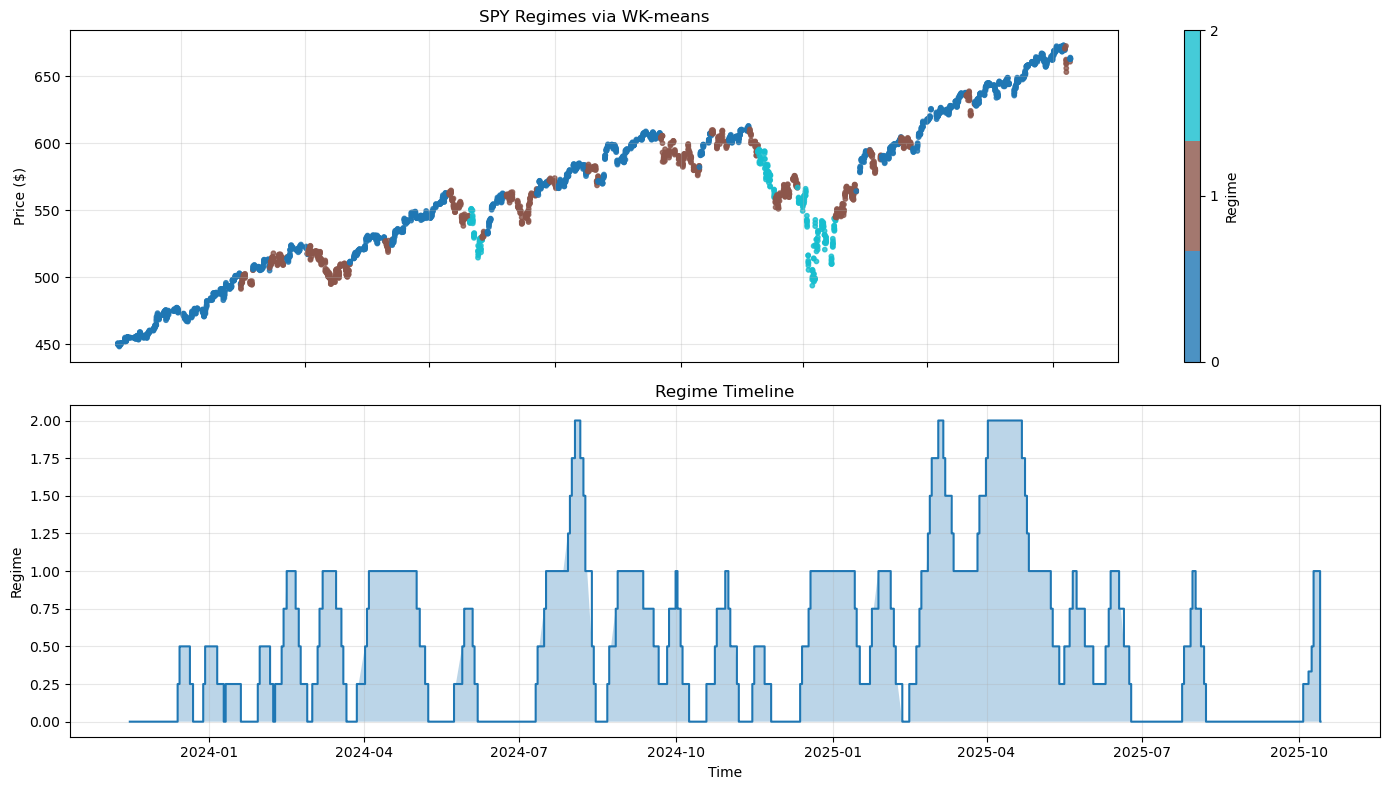

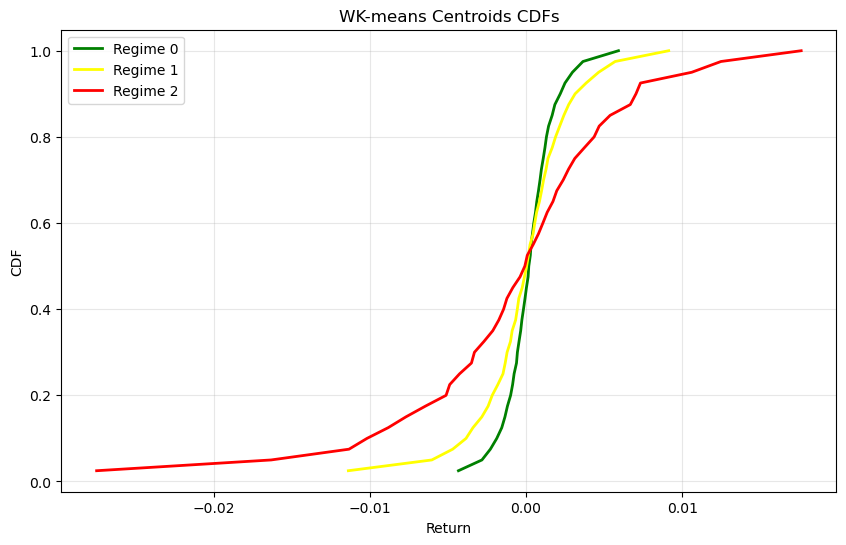

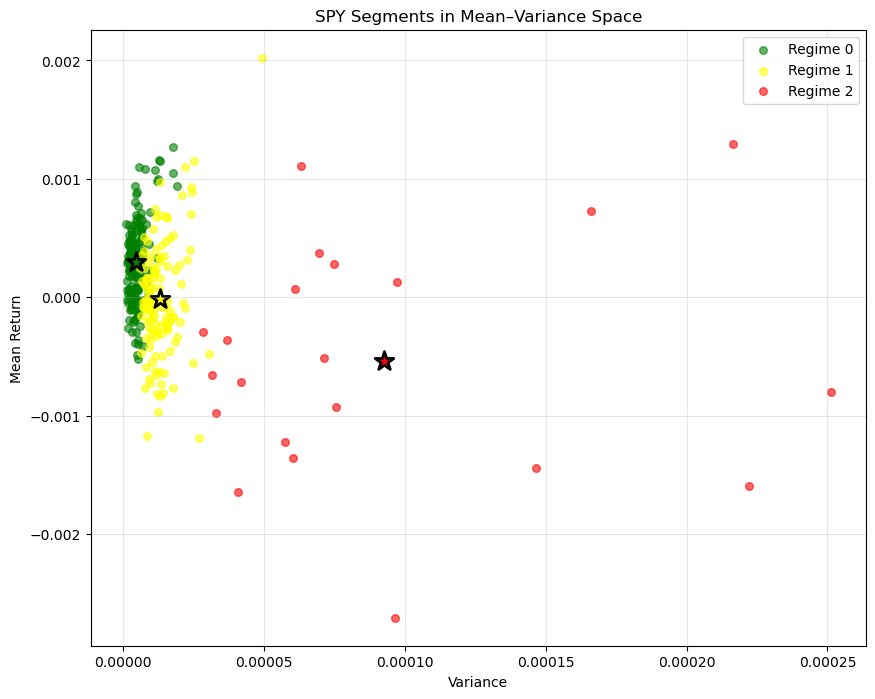


RUNNING TRADING STRATEGY BACKTEST


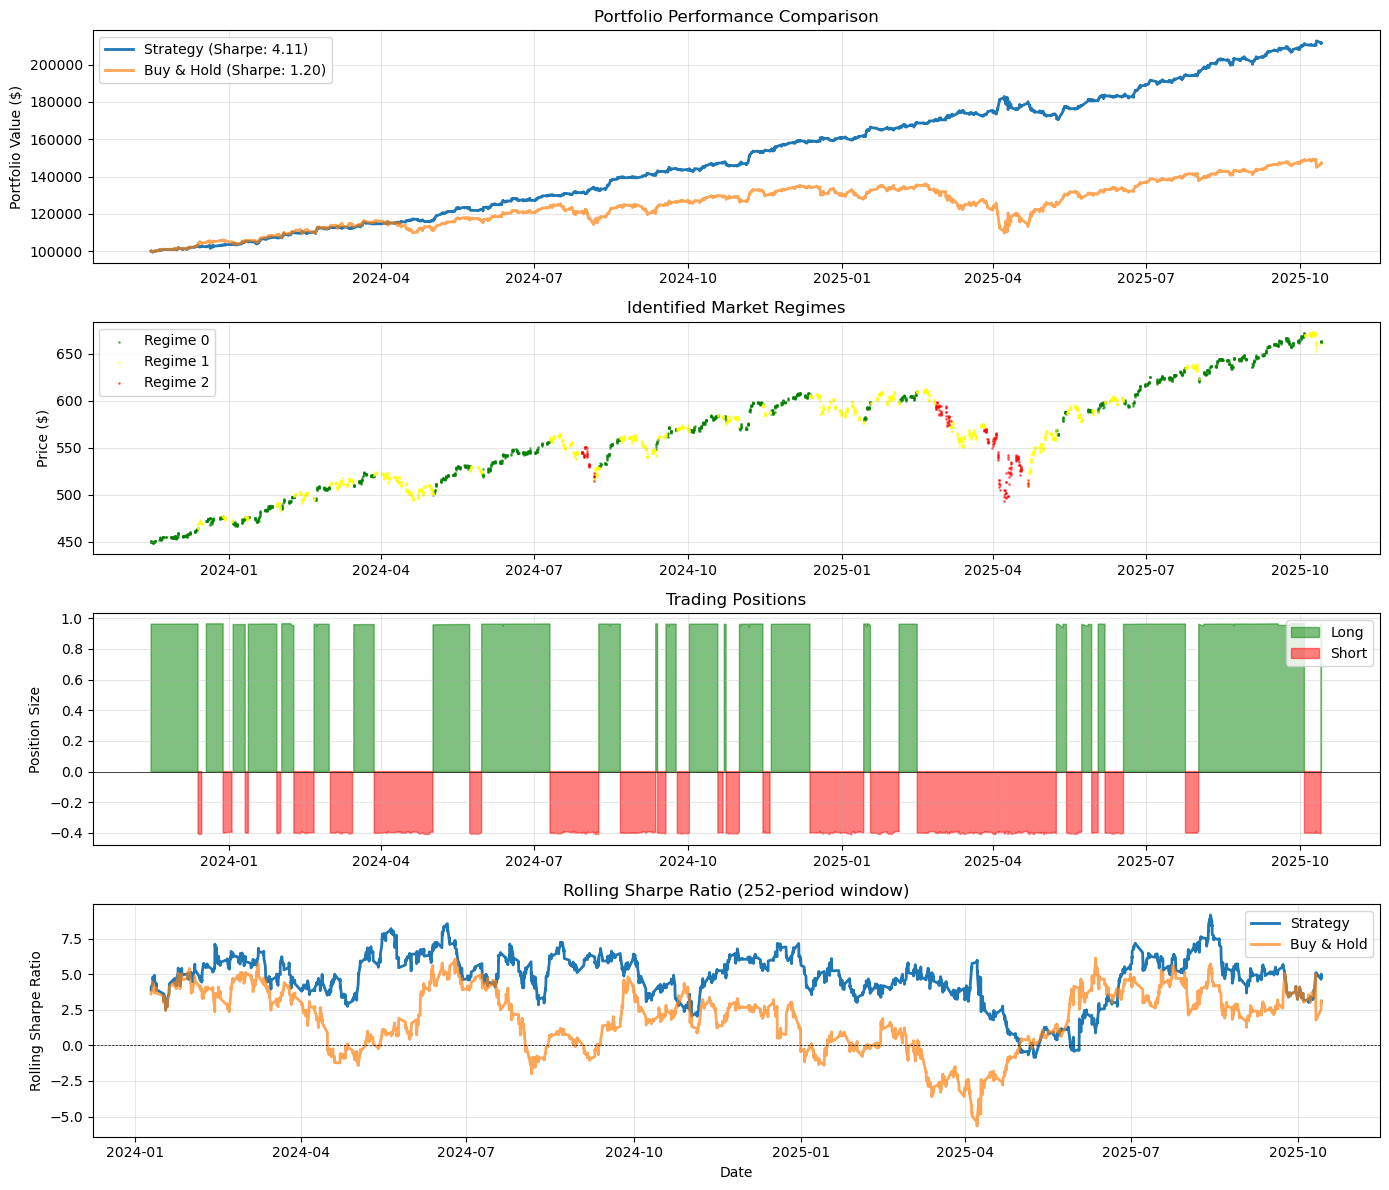


BACKTEST RESULTS SUMMARY
Total Return: 111.51%
Buy & Hold Return: 47.12%
Strategy Sharpe Ratio: 4.110
Buy & Hold Sharpe Ratio: 1.202
Max Drawdown: -6.79%
Buy & Hold Max Drawdown: -19.43%
Number of Trades: 123

Regime Characteristics (Wasserstein-based):

Regime 0:
  Occurrences: 176
  Mean Return: 0.0003
  Volatility: 0.0018
  Skewness: 0.41
  Kurtosis: 1.73
  95% VaR: -0.0023
  Sharpe: 5.78

Regime 1:
  Occurrences: 132
  Mean Return: -0.0000
  Volatility: 0.0033
  Skewness: -0.49
  Kurtosis: 2.80
  95% VaR: -0.0048
  Sharpe: -0.36

Regime 2:
  Occurrences: 21
  Mean Return: -0.0006
  Volatility: 0.0077
  Skewness: -0.82
  Kurtosis: 2.57
  95% VaR: -0.0116
  Sharpe: -2.79


In [11]:
# Execute everything with one function
result, strategy, backtest_results = run_complete_backtest()

# step by step:
# # 1. Run WK-means clustering
# result = run_wk_spy_pipeline(
#     start_date="2023-10-15",
#     end_date="2025-10-14",
#     k=3,  # Try 2-5 regimes
#     p=1   # L1 Wasserstein (more robust) or p=2 (smoother)
# )

# # 2. Initialize strategy
# strategy = WassersteinRegimeTradingStrategy(
#     window=40,
#     step=10,
#     k=3,
#     position_scalar=0.8,  # Use 80% of capital max
#     regime_transition_smoothing=3
# )

# # 3. Run backtest
# backtest_results = strategy.backtest(result)

# # 4. Visualize results
# strategy.plot_backtest_results(backtest_results, result)

## Real Time version

In [14]:
def _infer_periods_per_year(times):
        """Infer annualization factor from the timestamp spacing."""
        try:
            idx = pd.to_datetime(times)
        except Exception:
            return 252  # safe fallback (daily)

        if len(idx) < 3:
            return 252

        # median spacing in minutes
        dt_min = np.median(np.diff(idx.values).astype('timedelta64[m]')).astype(float)

        # Common cases
        if 55 <= dt_min <= 70:          # ~1h bars (RTH)
            return 252 * 6.5
        if dt_min >= 24*60 - 5:         # daily or slower
            return 252

        # Generic fallback: observed bars/day
        span_days = (idx[-1] - idx[0]).astype('timedelta64[s]').astype(float) / 86400.0
        bars_per_day = (len(idx) - 1) / max(span_days, 1e-9)
        return 252 * bars_per_day

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from dataclasses import dataclass
from typing import List
from scipy import stats
from scipy.optimize import linear_sum_assignment
import random, math, warnings
warnings.filterwarnings('ignore')

# ====================== WK-MEANS ======================
@dataclass
class WKMeansResult:
    centroids: np.ndarray     # shape (k, p)
    labels: np.ndarray        # shape (n,)
    losses: List[float]
    iter: int

class WassersteinKMeans:
    def __init__(self, n_clusters=2, p=2, max_iter=100, tol=1e-6, random_state=None):
        self.n_clusters = n_clusters
        self.p = p
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids_ = None
        self.labels_ = None
        if random_state is not None:
            np.random.seed(random_state)
            random.seed(random_state)
    
    def _wasserstein_empirical(self, alpha: np.ndarray, beta: np.ndarray, p=2):
        alpha = np.sort(np.array(alpha)); beta  = np.sort(np.array(beta))
        N = min(len(alpha), len(beta))
        return (np.mean(np.abs(alpha[:N] - beta[:N]) ** p)) ** (1 / p)
    
    def _wasserstein_barycenter(self, samples, p=2):
        N = len(samples[0])
        S = np.vstack([np.sort(s)[:N] for s in samples])
        return np.median(S, axis=0) if p == 1 else np.mean(S, axis=0)

    def fit(self, X):
        n_samples = len(X)
        if n_samples < self.n_clusters:
            raise ValueError("Number of samples must be >= number of clusters.")
        self.centroids_ = [X[i] for i in np.random.choice(n_samples, self.n_clusters, replace=False)]
        self.labels_ = np.zeros(n_samples, dtype=int)

        losses, iteration = [], 0
        while iteration < self.max_iter:
            # Assignment
            for i, sample in enumerate(X):
                distances = [self._wasserstein_empirical(sample, c, p=self.p) for c in self.centroids_]
                self.labels_[i] = np.argmin(distances)
            # Update
            new_centroids = []
            for j in range(self.n_clusters):
                cluster_members = [X[i] for i in range(n_samples) if self.labels_[i] == j]
                new_centroids.append(self._wasserstein_barycenter(cluster_members, p=self.p) if cluster_members else random.choice(X))
            # Convergence
            shift = sum(self._wasserstein_empirical(self.centroids_[j], new_centroids[j], p=self.p)
                        for j in range(self.n_clusters))
            self.centroids_ = new_centroids
            iteration += 1; losses.append(shift)
            if shift < self.tol: break

        return WKMeansResult(centroids=np.array(self.centroids_), labels=self.labels_, losses=losses, iter=iteration)
    
    def predict(self, X):
        labels = []
        for sample in X:
            distances = [self._wasserstein_empirical(sample, c, p=self.p) for c in self.centroids_]
            labels.append(np.argmin(distances))
        return np.array(labels)

# ====================== WALK-FORWARD STRATEGY ======================
class WassersteinRegimeTradingStrategy:
    """
    Walk-forward (rolling refit) online strategy:
    - Refit WK-means every `refit_every` bars on last `refit_lookback` returns.
    - Align cluster IDs across refits to keep Regime 0/1/2 consistent.
    - At bar t, classify trailing window log_returns[t-window:t] (ends at t-1) -> no look-ahead.
    """

    def __init__(self, window=40, step=10, k=3, p=1,
                 position_scalar=1.0, regime_transition_smoothing=3,
                 target_daily_vol=0.015):
        self.window = window
        self.step = step
        self.k = k
        self.p = p
        # in __init__
        self.max_leverage = 1.5          # allow up to 150% notional
        self.position_scalar = position_scalar
        self.regime_transition_smoothing = regime_transition_smoothing
        self.target_daily_vol = target_daily_vol
        
        self.regime_sharpe_halflife = 50  # segments (tune)
        self._alpha = 1 - 2**(-1/self.regime_sharpe_halflife)

    # ---- helpers ----
    def _centroid_stats_from_array(self, c):
        x = np.asarray(c); mu = float(np.mean(x)); sd = float(np.std(x))
        sk = float(stats.skew(x)); ku = float(stats.kurtosis(x))
        var95 = float(np.percentile(x, 5)); cvar95 = float(np.mean(x[x <= var95])) if np.any(x <= var95) else var95
        return dict(centroid_mean=mu, centroid_std=sd, centroid_skew=sk, centroid_kurt=ku, var95=var95, cvar95=cvar95)

    def _empty_online_stats(self):
        s0 = dict(mean_return=0.0, std_return=0.01, mean_sharpe=0.0,
                  ewm_sharpe=0.0, count=0)
        return [s0.copy() for _ in range(self.k)]

    def _update_online_stats(self, reg_stats, regime, seg, periods_per_year):
        mu  = float(np.mean(seg)); sd = float(np.std(seg)) or 1e-6
        sh  = (mu / sd) * np.sqrt(periods_per_year)
        rs  = reg_stats[regime]; n = rs['count'] + 1
        # simple means (kept if you still want them)
        rs['mean_return'] += (mu - rs['mean_return']) / n
        rs['std_return']  += (sd - rs['std_return'])   / n
        rs['mean_sharpe'] += (sh - rs['mean_sharpe'])  / n
        # EWMA (reactive)
        rs['ewm_sharpe']  = (1 - self._alpha) * rs.get('ewm_sharpe', 0.0) + self._alpha * sh
        rs['count'] = n

    def _scatter_to_segments(self, vec, window, step):
        segs = []
        for start in range(0, len(vec) - window + 1, step):
            segs.append(vec[start:start+window])
        return segs

    def _align_centroids(self, prev_c, new_c, p, wk_distance_fn):
        """Return new centroids and a mapping that best matches previous order (Hungarian)."""
        k = len(prev_c)
        D = np.zeros((k, k))
        for i in range(k):
            for j in range(k):
                D[i, j] = wk_distance_fn(prev_c[i], new_c[j], p=p)
        row_ind, col_ind = linear_sum_assignment(D)  # minimize total distance
        # reorder new centroids to match prev order
        new_ordered = [new_c[col_ind[i]] for i in range(k)]
        mapping_new_to_prev = {col_ind[i]: i for i in range(k)}  # j_new -> i_prev
        return new_ordered, mapping_new_to_prev

    def determine_position_advanced(self, current_regime, regime_stats, recent_regimes=None):
        # guard
        if current_regime is None or current_regime not in range(self.k):
            return 0.0

        s = regime_stats[current_regime]
        sharpe = float(s.get('ewm_sharpe', s.get('mean_sharpe', 0.0)))

        # <-- CENTROID METRICS ARE NESTED
        cstats = s.get('centroid_stats', {}) or {}
        skew = float(cstats.get('centroid_skew', 0.0))
        kurt = float(cstats.get('centroid_kurt', 0.0))
        var95 = float(cstats.get('var95', 0.0))
        vol  = float(cstats.get('centroid_std', 0.0))

        # Base rule
        if sharpe > 0.5 and skew > 0:
            position = 1.5
        elif sharpe > 0.5 and skew <= 0:
            position = 0.8
        elif sharpe > 0.0:
            position = 0.5
        elif sharpe > -0.3 and var95 > -0.02:
            position = -0.4
        elif sharpe <= -0.3 or var95 < -0.08:
            position = -1.0
        else:
            position = 0.0

        # Tail risk penalty
        if abs(kurt) > 3:
            position *= 0.7

        # Vol targeting — allow scaling UP, cap by max_leverage
        if vol > 0:
            vol_adj = min(self.max_leverage, self.target_daily_vol / vol)
            position *= vol_adj

        # Regime-transition damping
        if recent_regimes is not None and len(recent_regimes) >= self.regime_transition_smoothing:
            flips = sum(recent_regimes[i] != recent_regimes[i-1] for i in range(1, len(recent_regimes)))
            if flips > len(recent_regimes) * 0.5:
                position *= 0.5

        return float(np.clip(position * self.position_scalar, -self.max_leverage, self.max_leverage))
    
    # ---- metrics ----
    def calculate_sharpe(self, returns, periods_per_year, risk_free_rate=0.02):
        """
        Annualized Sharpe from per-bar arithmetic returns.
        - returns: 1D array-like of per-bar returns (ΔPV/PV_{t-1}), same bar size as prices
        - periods_per_year: e.g., 252*6.5 for 1h RTH; use _infer_periods_per_year(times)
        - risk_free_rate: annualized RF (e.g., 0.02 for 2%)
        """
        r = np.asarray(returns, dtype=float)
        r = r[np.isfinite(r)]
        if r.size < 2:
            return 0.0

        rf_per = risk_free_rate / periods_per_year
        excess = r - rf_per

        mu = float(np.mean(excess))
        sd = float(np.std(excess, ddof=1))  # sample stdev
        if sd <= 0:
            return 0.0

        return (mu / sd) * math.sqrt(periods_per_year)

    def calculate_max_drawdown(self, values):
        cummax = np.maximum.accumulate(values)
        return float(np.min((values - cummax) / cummax))

    # ---- WALK-FORWARD ONLINE BACKTEST ----
    def backtest_walkforward(self, prices, times=None,
                         warmup_bars=1000,        # initial fit size
                         refit_every=10,          # refit cadence (bars)
                         refit_lookback=1000,     # how much history to use for each refit
                         step_for_train=None,
                         transaction_cost=0.0003,
                         starting_capital=100000.0,
                         WassersteinKMeansClass=None):
        assert WassersteinKMeansClass is not None, "Pass WassersteinKMeansClass=WassersteinKMeans"

        prices = np.asarray(prices, dtype=float).reshape(-1)
        n = len(prices)
        assert warmup_bars >= self.window + 1, "warmup_bars must be >= window+1"
        assert n > warmup_bars, "Not enough data after warm-up."

        # Returns & annualization
        log_r = np.diff(np.log(prices))
        periods_per_year = _infer_periods_per_year(times)  # <-- inferred from timestamps
        step_train = self.step if step_for_train is None else step_for_train

        # --- initial fit on warm-up ---
        def seg_ts(vec): 
            return self._scatter_to_segments(vec, self.window, step_train)

        train_vec = log_r[:warmup_bars-1]
        train_segments = seg_ts(train_vec)
        assert len(train_segments) >= self.k, "Not enough warm-up segments."

        wk = WassersteinKMeansClass(n_clusters=self.k, p=self.p, random_state=42)
        wk_result = wk.fit(train_segments)
        centroids = list(wk_result.centroids)  # list for alignment
        centroid_stats = [self._centroid_stats_from_array(c) for c in centroids]

        # online stats per regime (carry across refits; aligned)
        online_stats = self._empty_online_stats()
        for k_idx in range(self.k):
            online_stats[k_idx]['centroid_stats'] = centroid_stats[k_idx]

        positions = np.zeros(n)
        portfolio_value = np.zeros(n); portfolio_value[0] = starting_capital
        cash = starting_capital; shares = 0.0
        regime_timeline = -np.ones(n, dtype=int)
        recent_regimes = []; trades = []

        # Record the Sharpe used for decisions at each bar (optional diagnostic)
        decision_sharpe = np.full(n, np.nan)

        # warm-up accounting (no trading)
        for t in range(1, warmup_bars):
            portfolio_value[t] = cash + shares * prices[t]
            positions[t] = 0.0

        t_start = max(warmup_bars, self.window)
        last_refit = t_start  # first trading bar

        # distance fn for alignment
        def wdist(a, b, p): 
            a = np.sort(np.asarray(a)); b = np.sort(np.asarray(b))
            N = min(len(a), len(b))
            return (np.mean(np.abs(a[:N] - b[:N]) ** p)) ** (1/p)

        # --- online loop ---
        for t in range(t_start, n):
            # ---- rolling refit on schedule (using only past up to t-1) ----
            if (t - last_refit) >= refit_every:
                start_idx = max(self.window, t - refit_lookback)
                refit_vec = log_r[start_idx : t]    # past-only
                refit_segments = seg_ts(refit_vec)
                if len(refit_segments) >= self.k:
                    wk_new = WassersteinKMeansClass(n_clusters=self.k, p=self.p, random_state=42)
                    wk_new_result = wk_new.fit(refit_segments)
                    new_centroids = list(wk_new_result.centroids)

                    # align new centroids to previous order
                    new_ordered, mapping_new_to_prev = self._align_centroids(
                        centroids, new_centroids, self.p, wdist
                    )
                    # reorder in the new wk object so predict() matches aligned order
                    wk = wk_new
                    wk.centroids_ = new_ordered  # enforce order
                    centroids = new_ordered
                    centroid_stats = [self._centroid_stats_from_array(c) for c in centroids]

                    # carry over online_stats to aligned indices
                    old_stats = online_stats
                    online_stats = self._empty_online_stats()
                    for j_new, i_prev in mapping_new_to_prev.items():
                        online_stats[i_prev] = old_stats[i_prev]  # keep same index meaning
                    # refresh centroid shape stats
                    for i in range(self.k):
                        online_stats[i]['centroid_stats'] = centroid_stats[i]

                    last_refit = t  # reset refit timer

            # ---- classify trailing window (ends at t-1) ----
            seg = log_r[t - self.window : t]
            current_regime = int(wk.predict([seg])[0])
            regime_timeline[t] = current_regime

            # update online regime stats
            self._update_online_stats(online_stats, current_regime, seg, periods_per_year)

            # capture the Sharpe used for sizing (annualized)
            decision_sharpe[t] = online_stats[current_regime]['mean_sharpe']

            # smoothing memory
            recent_regimes.append(current_regime)
            if len(recent_regimes) > self.regime_transition_smoothing * 2:
                recent_regimes.pop(0)

            # target position (NAV fraction)
            target_position = self.determine_position_advanced(current_regime, online_stats, recent_regimes)

            # dollars to adjust
            current_pos_val = shares * prices[t]
            target_pos_val  = target_position * portfolio_value[t-1]
            delta_val = target_pos_val - current_pos_val

            # execute with threshold and costs
            if abs(delta_val) > 0.01 * portfolio_value[t-1]:
                shares_to_trade = delta_val / prices[t]
                fee = abs(shares_to_trade * prices[t] * transaction_cost)
                shares += shares_to_trade
                cash   -= shares_to_trade * prices[t] + fee
                trades.append({'time': t, 'price': float(prices[t]), 'shares': float(shares_to_trade),
                               'position': float(target_position), 'regime': int(current_regime)})

            # mark-to-market
            portfolio_value[t] = cash + shares * prices[t]
            positions[t] = (shares * prices[t]) / portfolio_value[t] if portfolio_value[t] > 0 else 0.0

        # -------- performance (window-aligned Sharpe) --------
        # Full-series per-bar returns
        returns = np.diff(portfolio_value) / portfolio_value[:-1]
        buy_hold_returns_full = np.diff(prices) / prices[:-1]

        # Comparison window: from t_start -> end (fair apples-to-apples)
        strat_rets_cmp = returns[t_start:]                             # bars t_start .. end
        bh_rets_cmp    = np.diff(prices[t_start:]) / prices[t_start:-1]

        # Buy & Hold reference returns
        bh_return_full    = (prices[-1] / prices[0]) - 1.0
        bh_return_aligned = (prices[-1] / prices[t_start]) - 1.0

        results = {
            'portfolio_value': portfolio_value,
            'positions': positions,
            'returns': returns,                          # keep full (for other uses)
            'buy_hold_returns': buy_hold_returns_full,   # full per-bar B&H
            'regime_timeline': regime_timeline,
            'regime_stats': online_stats,
            'decision_sharpe': decision_sharpe,

            # Correct, window-aligned Sharpes (use your updated calculate_sharpe)
            'sharpe_ratio':    self.calculate_sharpe(strat_rets_cmp, periods_per_year),
            'buy_hold_sharpe': self.calculate_sharpe(bh_rets_cmp,    periods_per_year),

            'max_drawdown': self.calculate_max_drawdown(portfolio_value),
            'buy_hold_max_dd': self.calculate_max_drawdown(prices),  # (full-sample; keep if you prefer)
            'total_return': (portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0],
            'buy_hold_return': bh_return_aligned,        # aligned window (from t_start)
            'buy_hold_return_full': bh_return_full,      # full-sample reference
            'trades': trades,
            'n_trades': len(trades),
            'times': times if times is not None else None,
            't_start': t_start,
            'periods_per_year': periods_per_year,        # optional: handy for debugging
        }
        return results

In [18]:
def plot_performance_by_regime(results, title='Walk-Forward Wasserstein K-means: Performance by Regime'):
    """
    Plot cumulative strategy return (%), concatenated in the order observations occur
    for each regime. Uses results['regime_timeline'] and results['returns'].

    Expected in `results`:
      - regime_timeline: array-like of ints (length T) with -1 for invalid, 0..R-1 for regimes
      - returns: per-period strategy returns (length T-1), where returns[t-1] is for t-1 -> t
    """
    regimes = np.asarray(results.get('regime_timeline', []), dtype=float)
    returns = np.asarray(results.get('returns', []), dtype=float)

    if regimes.size == 0 or returns.size == 0:
        raise ValueError("Need results['regime_timeline'] and results['returns'].")

    # Determine number of regimes
    valid = regimes >= 0
    if not np.any(valid):
        raise ValueError("No valid regimes (all < 0).")
    n_regimes = int(np.nanmax(regimes[valid])) + 1

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Color cycle that supports many regimes
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i % 20) for i in range(n_regimes)]

    plotted_any = False
    for regime_id in range(n_regimes):
        rr = []
        # Use return for step t-1 -> t if regime at time t equals regime_id
        T = min(len(regimes), len(returns) + 1)
        for t in range(1, T):
            if regimes[t] >= 0 and int(regimes[t]) == regime_id:
                r = returns[t - 1]
                if np.isfinite(r):
                    rr.append(float(r))
        if rr:
            cum = np.cumprod(1.0 + np.asarray(rr)) - 1.0
            ax.plot(range(1, len(cum) + 1), 100.0 * cum, label=f'R{regime_id}',
                    linewidth=2, alpha=0.9, color=colors[regime_id])
            plotted_any = True

    if not plotted_any:
        plt.close(fig)
        raise ValueError("No finite returns found to plot for any regime.")

    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xlabel('Periods in Regime')
    ax.set_ylabel('Cumulative Return (%)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', ncol=min(n_regimes, 4), frameon=True)
    plt.tight_layout()
    return fig

def plot_online_results(prices, times, results, title="Walk-Forward WK-means vs Buy & Hold"):
    pv = results["portfolio_value"]
    positions = results["positions"]
    regimes = results["regime_timeline"]
    sharpe_used = results.get("decision_sharpe")
    t_start = int(results.get("t_start", 0))

    if times is None:
        times = np.arange(len(prices))

    # Rebase Buy & Hold at t_start so the comparison starts when trading actually begins
    anchor_value = float(pv[t_start])                 # match the strategy NAV at t_start
    bh_rebased = np.full_like(pv, np.nan, dtype=float)
    bh_rebased[t_start:] = anchor_value * (prices[t_start:] / prices[t_start])

    # 4 stacked plots
    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    # 1) PnL curves (B&H rebased at t_start)
    ax1 = axes[0]
    ax1.plot(times, pv, label="Strategy (NAV)", linewidth=2)
    label_date = times[t_start].date() if hasattr(times[t_start], "date") else str(times[t_start])
    ax1.plot(times, bh_rebased, label=f"Buy & Hold (rebased @ {label_date})", linewidth=2, alpha=0.75)
    ax1.axvline(times[t_start], linestyle="--", linewidth=1, alpha=0.6)
    ymax = ax1.get_ylim()[1]
    ax1.text(times[t_start], ymax, " start trading ", va="top", ha="left", fontsize=9)
    ax1.set_title(title)
    ax1.set_ylabel("Portfolio Value ($)")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # 2) Positions
    ax2 = axes[1]
    ax2.fill_between(times, positions, 0, where=(positions >= 0), alpha=0.5, label="Long")
    ax2.fill_between(times, positions, 0, where=(positions < 0),  alpha=0.5, label="Short")
    ax2.axhline(0, linewidth=0.5)
    ax2.set_ylabel("Position (NAV frac)")
    ax2.set_title("Trading Positions")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # 3) Decision Sharpe trace
    ax3 = axes[2]
    if sharpe_used is not None:
        mask = ~np.isnan(sharpe_used)
        ax3.plot(times[mask], sharpe_used[mask], linewidth=1.6, label="Decision Sharpe")
        ax3.axhline(0.5, linestyle="--", linewidth=1, alpha=0.8, label="> 0.5 (bullish)")
        ax3.axhline(0.0, linestyle=":",  linewidth=1, alpha=0.8, label="0.0")
        ax3.axhline(-0.3, linestyle="--", linewidth=1, alpha=0.8, label="< -0.3 (bearish)")
    ax3.set_ylabel("Sharpe (ann.)")
    ax3.set_title("Sharpe used for Position Sizing")
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc="upper left")

    # 4) Regime timeline
    ax4 = axes[3]
    mask_reg = regimes >= 0
    ax4.step(times[mask_reg], regimes[mask_reg], where="post")
    ax4.set_ylabel("Regime")
    ax4.set_xlabel("Time")
    ax4.set_title("Online Regime Timeline")
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # =================== SUMMARY PRINT ===================
    print("\n" + "="*60)
    print("BACKTEST RESULTS SUMMARY")
    print("="*60)
    print(f"Total Return: {results['total_return']:.2%}")
    print(f"Buy & Hold Return (from start of trading): {results['buy_hold_return']:.2%}")
    print(f"(Reference) Buy & Hold Return full sample: {results['buy_hold_return_full']:.2%}")
    print(f"Strategy Sharpe Ratio: {results['sharpe_ratio']:.3f}")
    print(f"Buy & Hold Sharpe Ratio: {results['buy_hold_sharpe']:.3f}")
    print(f"Max Drawdown: {results['max_drawdown']:.2%}")
    print(f"Buy & Hold Max Drawdown: {results['buy_hold_max_dd']:.2%}")
    print(f"Number of Trades: {results['n_trades']}")

    # -------- Regime Characteristics (Wasserstein-based) --------
    print("\nRegime Characteristics (Wasserstein-based):\n")

    rets_full = np.asarray(results.get("returns", []), dtype=float)
    regimes_full = np.asarray(results.get("regime_timeline", []), dtype=float)
    ppy = float(results.get("periods_per_year", 252 * 6.5))
    if rets_full.size and regimes_full.size:
        start = max(1, int(results.get("t_start", 0)))  # align with comparison window
        n_regs = int(np.nanmax(regimes_full[regimes_full >= 0])) + 1 if np.any(regimes_full >= 0) else 0

        for rid in range(n_regs):
            # Per-bar returns assigned to regime rid when regime at time t == rid
            rr = [rets_full[t-1] for t in range(start, len(regimes_full))
                  if regimes_full[t] == rid and np.isfinite(rets_full[t-1])]
            occ = int(np.sum(regimes_full[start:] == rid))

            if len(rr) >= 1:
                rr = np.asarray(rr, dtype=float)
                mu  = float(np.mean(rr))
                sd  = float(np.std(rr, ddof=1)) if len(rr) > 1 else 0.0
                sk  = float(stats.skew(rr)) if len(rr) > 2 else 0.0
                ku  = float(stats.kurtosis(rr)) if len(rr) > 3 else 0.0
                var = float(np.percentile(rr, 5)) if len(rr) > 0 else 0.0
                sh  = (mu / sd) * math.sqrt(ppy) if sd > 0 else 0.0
            else:
                mu = sd = sk = ku = var = sh = 0.0

            print(f"Regime {rid}:")
            print(f"  Occurrences: {occ}")
            print(f"  Mean Return: {mu:.4f}")
            print(f"  Volatility: {sd:.4f}")
            print(f"  Skewness: {sk:.2f}")
            print(f"  Kurtosis: {ku:.2f}")
            print(f"  95% VaR: {var:.4f}")
            print(f"  Sharpe: {sh:.2f}\n")
    else:
        print("(No regime/return data available to summarize.)")
    
def main_walkforward(
    start_date="2023-11-15",
    end_date="2025-10-14",
    interval="1h",
    window=40,
    step=10,
    k=3,
    p=1,
    warmup_bars=1000,        # initial fit only
    refit_every=20,         # refit every 250 bars
    refit_lookback=3000,     # use last 3000 bars for each refit
    transaction_cost=0.0003,
    starting_capital=100000.0
):
    print(f"Downloading SPY {interval} data from {start_date} to {end_date}...")
    spy = yf.download("SPY", start=start_date, end=end_date, interval=interval, progress=False)
    if spy.empty:
        print("Hourly failed; trying daily.")
        interval = "1d"
        spy = yf.download("SPY", start=start_date, end=end_date, interval=interval, progress=False)
        if spy.empty: raise ValueError("Failed to download SPY data.")
    prices = spy["Close"].to_numpy(dtype=float).reshape(-1); times = spy.index
    n = len(prices)
    if warmup_bars < window + 1: warmup_bars = window + 1
    if n <= max(warmup_bars, window) + 1: raise ValueError("Not enough data after warm-up. Extend date range.")

    strat = WassersteinRegimeTradingStrategy(window=window, step=step, k=k, p=p,
                                             position_scalar=1.0, regime_transition_smoothing=3,
                                             target_daily_vol=0.015)

    results = strat.backtest_walkforward(
        prices=prices, times=times,
        warmup_bars=warmup_bars,
        refit_every=refit_every,
        refit_lookback=refit_lookback,
        transaction_cost=transaction_cost,
        starting_capital=starting_capital,
        WassersteinKMeansClass=WassersteinKMeans
    )

    plot_online_results(prices, times, results,
                        title=f"Walk-Forward WK-means (k={k}, window={window}, step={step}, interval={interval})")
    
    return results

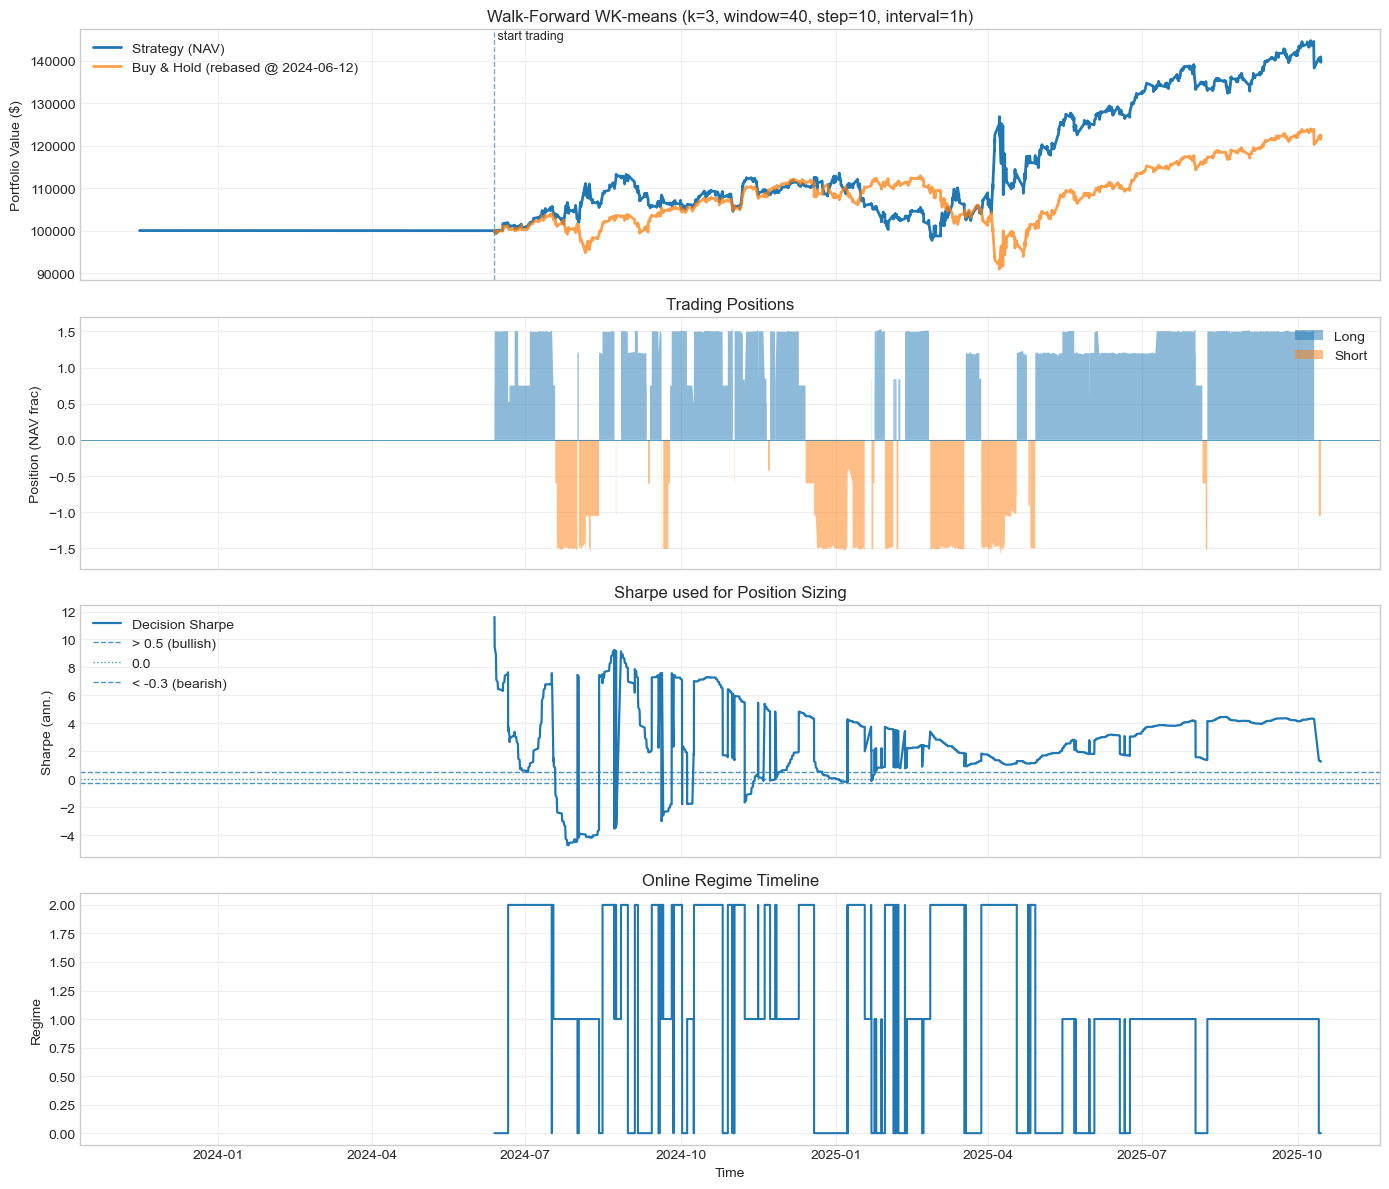


BACKTEST RESULTS SUMMARY
Total Return: 40.33%
Buy & Hold Return (from start of trading): 21.97%
(Reference) Buy & Hold Return full sample: 46.93%
Strategy Sharpe Ratio: 1.055
Buy & Hold Sharpe Ratio: 0.798
Max Drawdown: -14.47%
Buy & Hold Max Drawdown: -19.43%
Number of Trades: 488

Regime Characteristics (Wasserstein-based):

Regime 0:
  Occurrences: 577
  Mean Return: 0.0001
  Volatility: 0.0050
  Skewness: 1.23
  Kurtosis: 12.01
  95% VaR: -0.0063
  Sharpe: 1.05

Regime 1:
  Occurrences: 978
  Mean Return: 0.0001
  Volatility: 0.0043
  Skewness: 1.65
  Kurtosis: 31.56
  95% VaR: -0.0052
  Sharpe: 1.04

Regime 2:
  Occurrences: 778
  Mean Return: 0.0003
  Volatility: 0.0076
  Skewness: -0.25
  Kurtosis: 28.43
  95% VaR: -0.0082
  Sharpe: 1.34



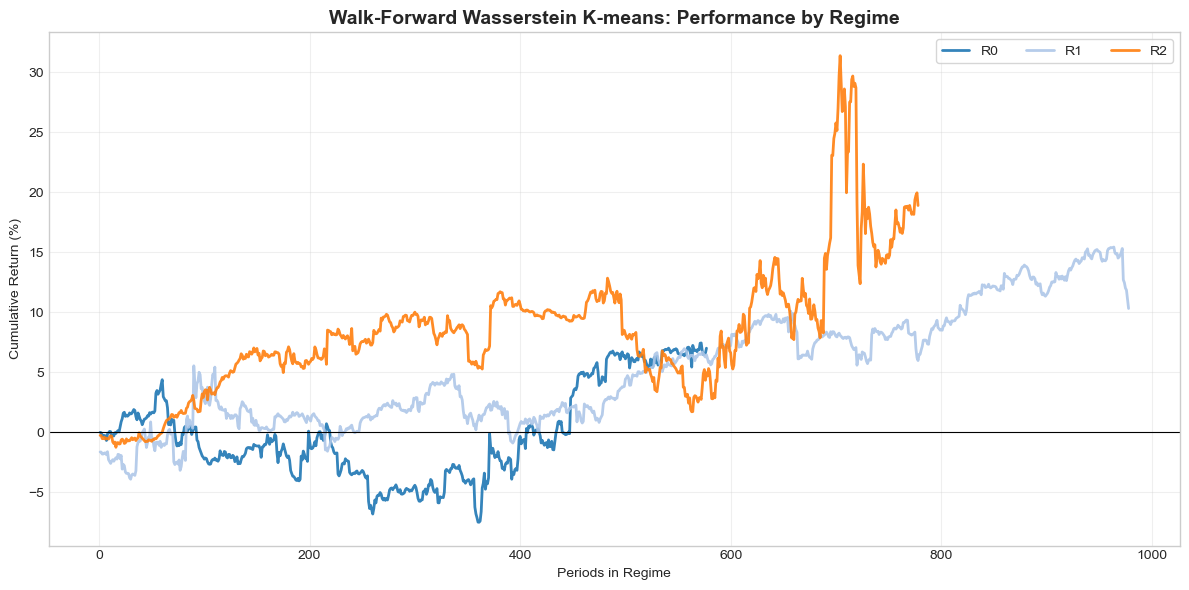

In [19]:
if __name__ == "__main__":
    results = main_walkforward(
        start_date="2023-11-15",
        end_date="2025-10-15",
        interval="1h",
        window=40,
        step=10,
        k=3,
        p=1,
        warmup_bars=1000,
        refit_every=10,
        refit_lookback=1000,
        transaction_cost=0.0003,
        starting_capital=100000.0
    )

    fig = plot_performance_by_regime(results)
    plt.show()